In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing import image
from PIL import Image

In [2]:
meta=pd.read_csv("../input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv")
print(f'Shape: {meta.shape}')

Shape: (5910, 6)


In [3]:
meta.sample(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5663,5686,person118_bacteria_560.jpeg,Pnemonia,TEST,NaN,bacteria
5043,5043,person983_virus_1660.jpeg,Pnemonia,TRAIN,NaN,Virus
613,613,IM-0750-0001.jpeg,Normal,TRAIN,NaN,NaN
5837,5860,person24_virus_58.jpeg,Pnemonia,TEST,NaN,Virus
1943,1943,person1324_virus_2284.jpeg,Pnemonia,TRAIN,NaN,Virus
2700,2700,person1713_bacteria_4530.jpeg,Pnemonia,TRAIN,NaN,bacteria
2628,2628,person1522_bacteria_3977.jpeg,Pnemonia,TRAIN,NaN,bacteria
1679,1679,person124_virus_236.jpeg,Pnemonia,TRAIN,NaN,Virus
1392,1392,person1153_virus_1932.jpeg,Pnemonia,TRAIN,NaN,Virus
1952,1952,person1321_bacteria_3358.jpeg,Pnemonia,TRAIN,NaN,bacteria


In [4]:
summ=pd.read_csv("../input/coronahack-chest-xraydataset/Chest_xray_Corona_dataset_Summary.csv")
print(f'Shape: {summ.shape}')

Shape: (7, 5)


In [5]:
summ.sample(7)

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
6,6,Pnemonia,bacteria,Streptococcus,5
5,5,Pnemonia,bacteria,NaN,2772
4,4,Pnemonia,Virus,SARS,4
3,3,Pnemonia,Virus,COVID-19,58
0,0,Normal,NaN,NaN,1576
2,2,Pnemonia,Virus,NaN,1493
1,1,Pnemonia,Stress-Smoking,ARDS,2


In [6]:
print(f'Label counts in metadata:\n\n{meta.Label.value_counts()}')

Label counts in metadata:

Pnemonia    4334
Normal      1576
Name: Label, dtype: int64


In [7]:
print(f'Label-1 counts:\n\n{meta.Label_1_Virus_category.value_counts()}')

Label-1 counts:

bacteria          2777
Virus             1555
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64


In [8]:
print(f'Label-2 counts:\n\n{meta.Label_2_Virus_category.value_counts()}')

Label-2 counts:

COVID-19         58
Streptococcus     5
SARS              4
ARDS              2
Name: Label_2_Virus_category, dtype: int64


In [9]:
print(f'Null counts in metdata:\n\n{meta.isnull().sum()}')

Null counts in metdata:

Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64


In [10]:
train_df = meta[meta.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_df = meta[meta.Dataset_type == 'TEST'].reset_index(drop=True)
assert train_df.shape[0] + test_df.shape[0] == meta.shape[0]
print(f'Train df shape: {train_df.shape}')
print(f'Test df shape: {test_df.shape}')

Train df shape: (5286, 6)
Test df shape: (624, 6)


In [11]:
print(f'Count of null values in train:\n{train_df.isnull().sum()}')
print(f'\nCount of null values in test:\n{test_df.isnull().sum()}')

Count of null values in train:
Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5217
Label_1_Virus_category    1342
dtype: int64

Count of null values in test:
Unnamed: 0                  0
X_ray_image_name            0
Label                       0
Dataset_type                0
Label_2_Virus_category    624
Label_1_Virus_category    234
dtype: int64


In [12]:
train_df = train_df.fillna('NA')
test_df = test_df.fillna('NA')

train_df.sample(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
1045,1045,NORMAL2-IM-0987-0001.jpeg,Normal,TRAIN,NA,NA
82,82,IM-0277-0001.jpeg,Normal,TRAIN,NA,NA
2105,2105,person1432_bacteria_3699.jpeg,Pnemonia,TRAIN,NA,bacteria
1677,1677,person124_virus_238.jpeg,Pnemonia,TRAIN,NA,Virus
1018,1018,NORMAL2-IM-0945-0001.jpeg,Normal,TRAIN,NA,NA


In [13]:
test_df.sample(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
398,5707,person109_bacteria_528.jpeg,Pnemonia,TEST,NA,bacteria
39,5348,IM-0109-0001.jpeg,Normal,TEST,NA,NA
621,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NA,Virus
366,5675,person121_bacteria_576.jpeg,Pnemonia,TEST,NA,bacteria
176,5485,NORMAL2-IM-0141-0001.jpeg,Normal,TEST,NA,NA


In [14]:
test_df[test_df.Label == 'Pnemonia'].sample(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
456,5765,person87_bacteria_433.jpeg,Pnemonia,TEST,NA,bacteria
547,5856,person28_virus_63.jpeg,Pnemonia,TEST,NA,Virus
485,5794,person78_virus_140.jpeg,Pnemonia,TEST,NA,Virus
289,5598,person146_bacteria_703.jpeg,Pnemonia,TEST,NA,bacteria
313,5622,person138_bacteria_658.jpeg,Pnemonia,TEST,NA,bacteria


In [15]:
train_img="../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
test_img="../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"

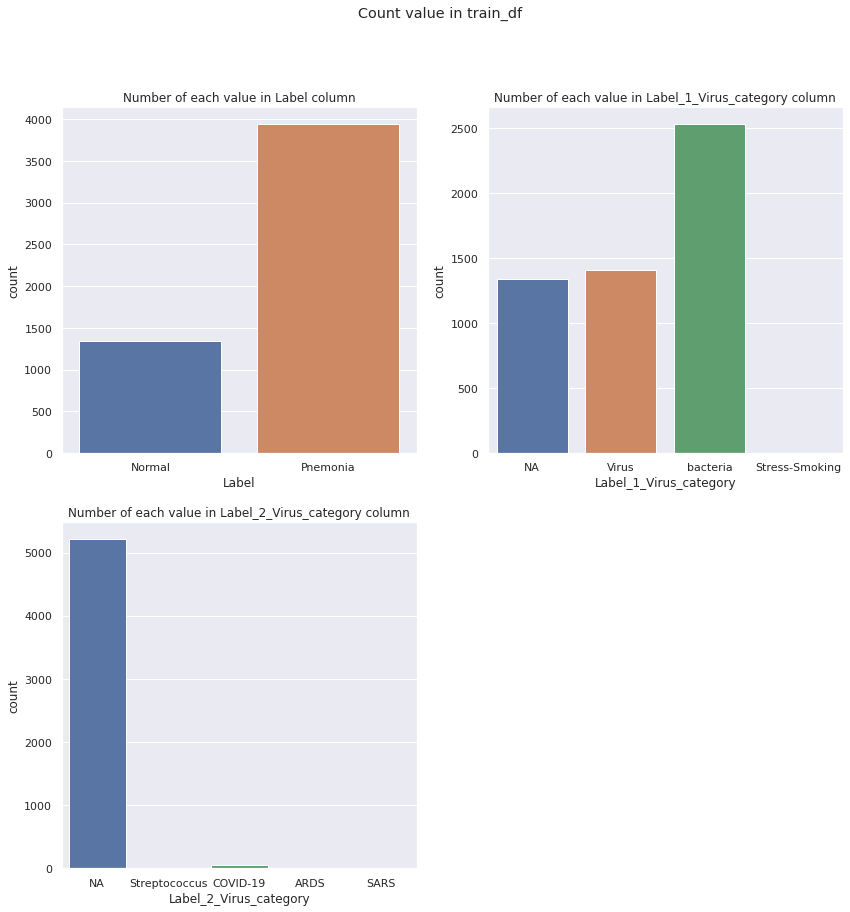

In [16]:
import matplotlib.pyplot as plt
col = ['Label', 'Label_1_Virus_category', 'Label_2_Virus_category']

sns.set_theme(style='darkgrid')
fig = plt.figure(figsize=(14, 14))
for i in range(3):
    ax = plt.subplot(2, 2, i + 1)
    ax = sns.countplot(x=col[i], data=train_df)
    ax.set_title(f'Number of each value in {col[i]} column')
fig.suptitle('Count value in train_df')
plt.show()

In [17]:
pnemonia_df = train_df[train_df.Label == 'Pnemonia']
print(f'Number of pnemonia in training dataset: { len(pnemonia_df) }')

Number of pnemonia in training dataset: 3944


In [18]:
pnemonia_without_unknow_df = pnemonia_df[pnemonia_df.Label_2_Virus_category != 'NA']
print(f'Number of pnemonia without unknow value in Label_2_Virus_category: { len(pnemonia_without_unknow_df) }')

Number of pnemonia without unknow value in Label_2_Virus_category: 69


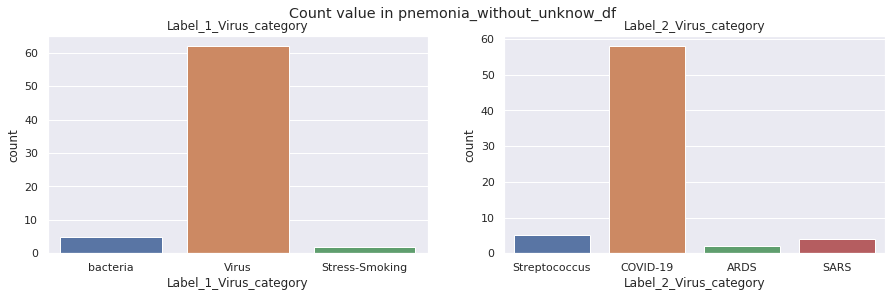

In [19]:
fig = plt.figure(figsize=(15, 4))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    ax = sns.countplot(x=col[i+1], data=pnemonia_without_unknow_df)
    ax.set_title(col[i+1])
fig.suptitle('Count value in pnemonia_without_unknow_df')
plt.show()

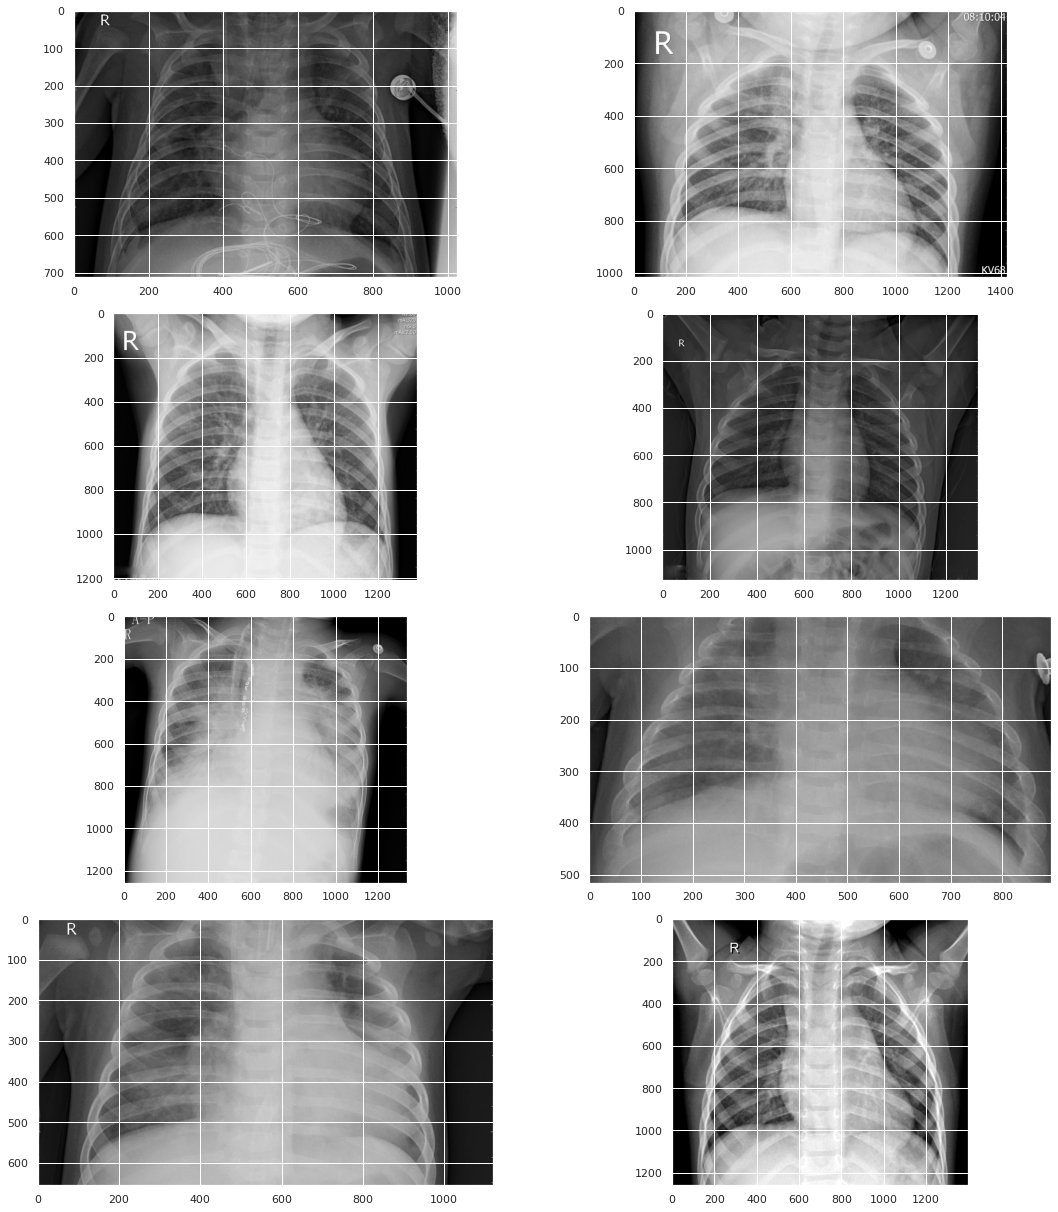

In [20]:
assert os.path.isdir(train_img) == True
sample_train_images = list(os.walk(train_img))[0][2][:8]
sample_train_images = list(map(lambda x: os.path.join(train_img, x), sample_train_images))
plt.figure(figsize = (17,17))
for iterator, filename in enumerate(sample_train_images):
    image = Image.open(filename)
    plt.subplot(4,2,iterator+1)
    plt.imshow(image,cmap='gray')

plt.tight_layout()

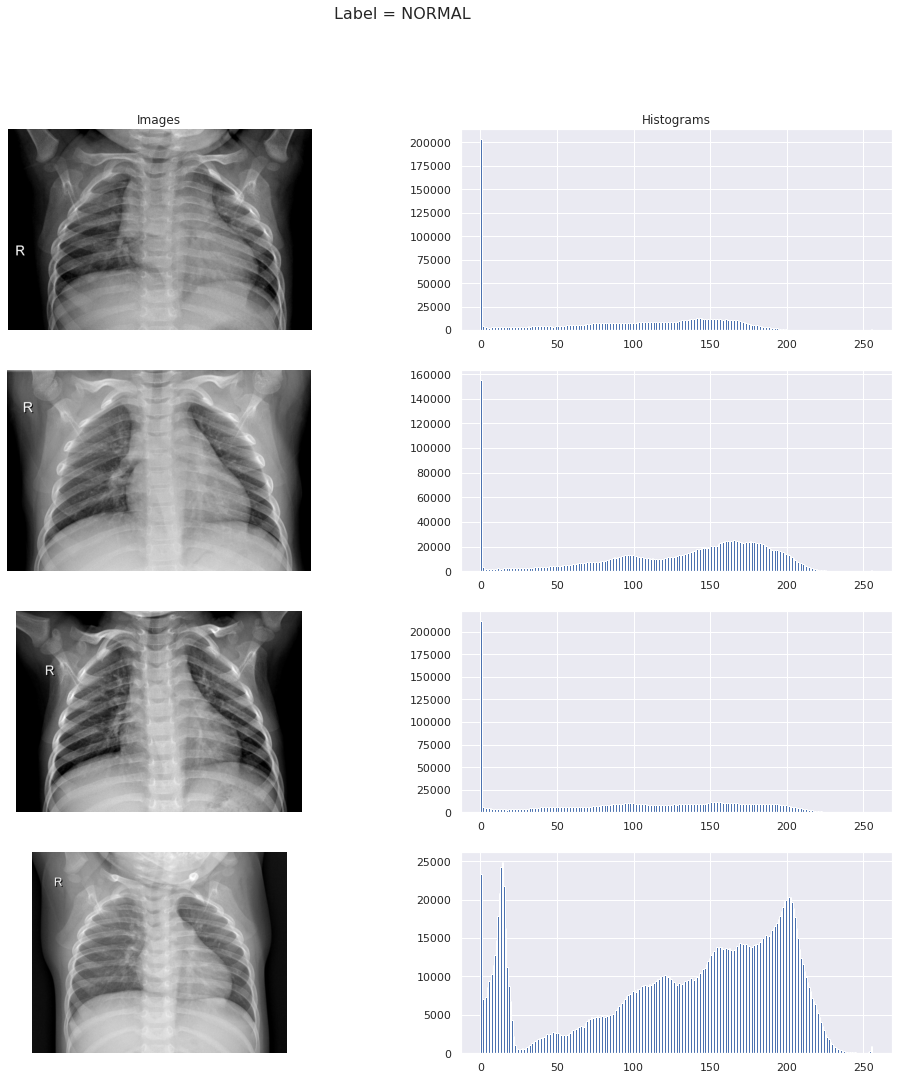

In [21]:
fig, ax = plt.subplots(4, 2, figsize=(17, 17))
normal_path = train_df[train_df['Label']=='Normal']['X_ray_image_name'].values

sample_normal_path = normal_path[:4]
sample_normal_path = list(map(lambda x: os.path.join(train_img, x), sample_normal_path))

for row, file in enumerate(sample_normal_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image,cmap='gray')
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label = NORMAL', size=16)
plt.show()

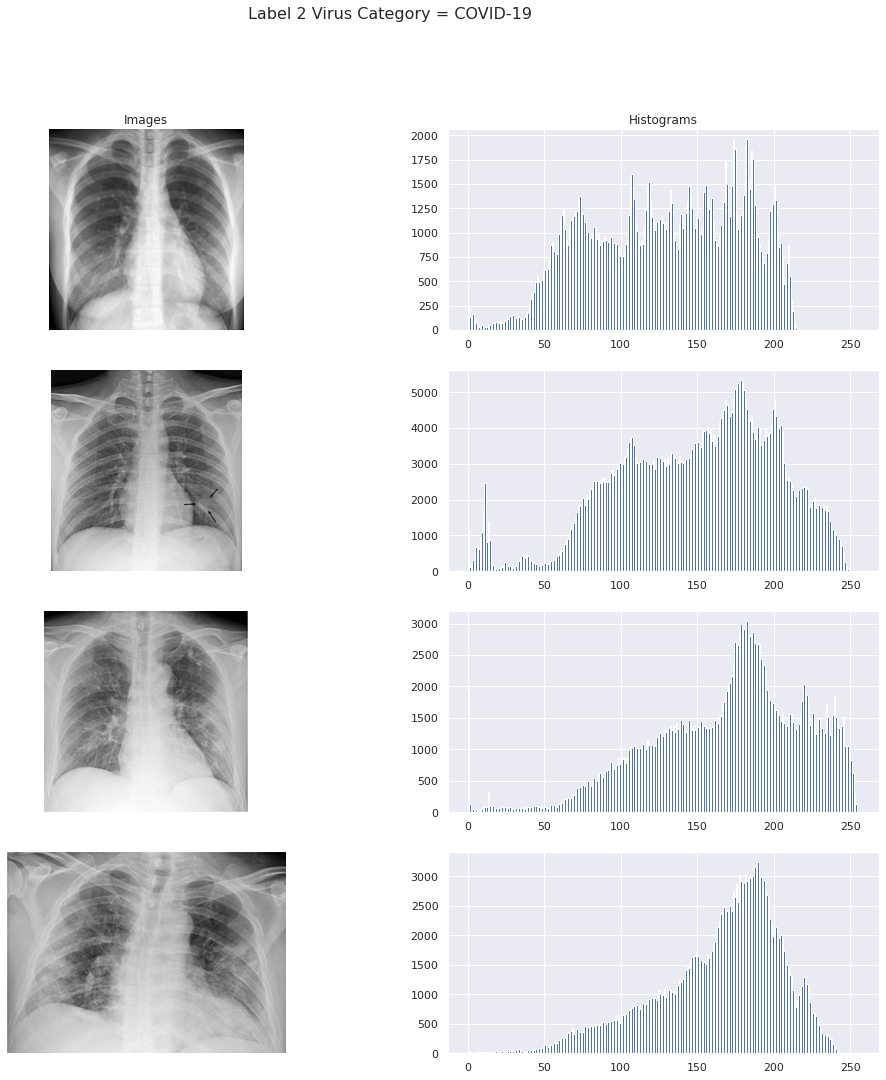

In [22]:
fig, ax = plt.subplots(4, 2, figsize=(17, 17))
covid_path = train_df[train_df['Label_2_Virus_category']=='COVID-19']['X_ray_image_name'].values

sample_covid_path = covid_path[:4]
sample_covid_path = list(map(lambda x: os.path.join(train_img, x), sample_covid_path))

for row, file in enumerate(sample_covid_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image,cmap='gray')
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label 2 Virus Category = COVID-19', size=16)
plt.show()

In [23]:
test_df['Label'].value_counts()

Pnemonia    390
Normal      234
Name: Label, dtype: int64

In [24]:
meta.Dataset_type.value_counts()

TRAIN    5286
TEST      624
Name: Dataset_type, dtype: int64

In [25]:
train_data = meta[meta['Dataset_type'] == 'TRAIN']
test_data = meta[meta['Dataset_type'] == 'TEST']

In [26]:
def create_directory():
    try:
        os.makedirs('../working/train/Pnemonia')
        os.makedirs('../working/train/Normal')
        os.makedirs('../working/test/Pnemonia')
        os.makedirs('../working/test/Normal')
    except:
        pass

In [27]:
create_directory()

In [28]:
import shutil
train_pnemonia = '../working/train/Pnemonia/'
source_train = "../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
move_train_pnemonia = train_data[ train_data['Label'] == 'Pnemonia']['X_ray_image_name'].values
for i in move_train_pnemonia:
    path = os.path.join(source_train,i)
    shutil.copy(path,train_pnemonia)
    
#Normal
train_normal = '../working/train/Normal/'
move_train_normal = train_data[train_data.Label == 'Normal']['X_ray_image_name'].values
for i in move_train_normal:
    path = os.path.join(source_train,i)
    shutil.copy(path,train_normal)

In [29]:
test_pnemonia = '../working/test/Pnemonia/'
source_test = "../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"
move_test_pnemonia = test_data[test_data['Label'] == 'Pnemonia']['X_ray_image_name'].values
                               
for i in move_test_pnemonia:
    
    path2 = os.path.join(source_test, i)
    shutil.copy(path2, test_pnemonia)

test_normal = '../working/test/Normal/'
move_test_normal = test_data[test_data.Label == 'Normal']['X_ray_image_name'].values
for i in move_test_normal:
    path3 = os.path.join(source_test, i)
    shutil.copy(path3, test_normal)

In [30]:
train_datagen = ImageDataGenerator(rescale = 1/255, rotation_range = 0.2, 
                              zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1/255)

In [31]:
train_gen = train_datagen.flow_from_directory("../working/train/", target_size = (200,200),
                                             batch_size = 50, class_mode = 'binary', 
                                              subset= 'training')
valid_gen = train_datagen.flow_from_directory("../working/train/", target_size = (200,200),
                                             batch_size = 50, class_mode = 'binary', 
                                              subset= 'validation')
test_gen = test_datagen.flow_from_directory("../working/test/", target_size = (200,200),
                                             batch_size = 50, class_mode = 'binary')

Found 4230 images belonging to 2 classes.
Found 1056 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [32]:
print(train_gen.class_indices)

{'Normal': 0, 'Pnemonia': 1}


In [33]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(3,3), activation= 'relu',
                                                          input_shape= (200,200,3)),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   tf.keras.layers.Conv2D(32,(3,3), activation= 'relu'),
                                    
                                   tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Conv2D(32,(3,3), activation= 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Conv2D(32,(3,3), activation= 'relu'),
                                   tf.keras.layers.MaxPool2D(2,2),
                                    
                                   tf.keras.layers.Flatten(),
                                   tf.keras.layers.Dense(1, activation = 'relu'),
                                   tf.keras.layers.Dense(1,activation = 'sigmoid')])
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
model.compile(optimizer=RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_gen, validation_data = valid_gen, epochs = 10, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/10
85/85 [==============================] - 160s 2s/step - loss: 0.6925 - accuracy: 0.7214 - val_loss: 0.6909 - val_accuracy: 0.7462
Epoch 2/10
85/85 [==============================] - 146s 2s/step - loss: 0.6905 - accuracy: 0.7356 - val_loss: 0.6889 - val_accuracy: 0.7462
Epoch 3/10
85/85 [==============================] - 146s 2s/step - loss: 0.6886 - accuracy: 0.7361 - val_loss: 0.6869 - val_accuracy: 0.7462
Epoch 4/10
85/85 [==============================] - 146s 2s/step - loss: 0.6864 - accuracy: 0.7484 - val_loss: 0.6849 - val_accuracy: 0.7462
Epoch 5/10
85/85 [==============================] - 160s 2s/step - loss: 0.6846 - accuracy: 0.7409 - val_loss: 0.6830 - val_accuracy: 0.7462
Epoch 6/10
85/85 [==============================] - 147s 2s/step - loss: 0.6828 - accuracy: 0.7404 - val_loss: 0.6811 - val_accuracy: 0.7462
Epoch 7/10
85/85 [==============================] - 147s 2s/step - loss: 0.6807 - accuracy: 0.7434 - val_loss: 0.6792 - val_accuracy: 0.7462
Epoch 8/10
85

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pred = (model.predict(test_gen)>0.5).astype("int32")

y_test = test_gen.labels
print('Classification report:\n', classification_report(y_test, pred))
print('Accuracy score:\n', accuracy_score(y_test, pred))

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624

Accuracy score:
 0.625


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
pred_class= model.predict_classes(test_gen)
print('Classification report:\n', classification_report(y_test, pred_class))
print('Accuracy Score:\n', accuracy_score(y_test, pred_class))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624

Accuracy Score:
 0.625


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
from keras.models import load_model
model.save('model_lung_x-ray.h5')
